# Training Pipeline

All dataloading and training in one place!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from datetime import datetime
from tqdm.notebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Union
import pickle
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_f1_score

#Local packages
from src import CNNDetector, ContrastiveDetector

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
"""
Configure

Change the paths of the data directory to the location of your HMS Dataset.
The sub directories of TRAIN/TEST_EEG, TRAIN/TEST_SPEC should remain the same

"""

#Kaggle
# DATA_ROOT = "/kaggle/input/hms-harmful-brain-activity-classification/"
# TRAIN_EEG = "train_eegs"
# TRAIN_SPEC = "train_spectrograms"
# TEST_EEG = "test_eegs"
# TEST_SPEC = "test_spectrograms"

#Local
DATA_ROOT = "/home/benluo/HBAC/data/hbac"
TRAIN_EEG = "train_eegs"
TRAIN_SPEC = "train_spectrograms"
TEST_EEG = "test_eegs"
TEST_SPEC = "test_spectrograms"

#Other hyperparams
VALID_FOLDS = 5

In [3]:
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Reduce train dataset size

The code below only takes the first portion of data in the training list to reduce the number of spectrogram and EEG samples in the training dataset

You can choose not to run the following cell if `train_reduced.csv` already exists

In [4]:
#Get reduced train list as the entire dataset is heavy on RAM, 

reduce_train_path = os.path.join(DATA_ROOT, "train_reduced.csv")

if os.path.isfile(reduce_train_path):

    print("train_reduced.csv already exists")

else:

    train_list = pd.read_csv(os.path.join(DATA_ROOT, "train.csv"))

    reduced_len = train_list.shape[0]//2 #32 GB of RAM during training
    # reduced_len = train_list.shape[0]//4 #Less RAM but less data

    train_list_reduced = train_list.iloc[:reduced_len,:]

    train_list_reduced.to_csv(os.path.join(DATA_ROOT, "train_reduced.csv"))

train_reduced.csv already exists


### Generate Data

Since test data does not come with labels, for local training and testing, we will only use the data from `train.csv`

The Dataset follows a train-val-test split.

The train and test datasets are split first by `test_size`.

The train and validation datasets are split by Group K-Folds into `val_folds` uniform groups. One group will be chosen randomly for validation while the rest will be used for training every epoch.

In [5]:
def generate_data(val_folds:int = VALID_FOLDS,
                  test_size:float = 0.1,
                  saved_spec:str = "all_spec.pkl",
                  saved_eeg:str = "all_eeg.pkl"):

    #Use reduced csv file
    train_list = pd.read_csv(os.path.join(DATA_ROOT, "train_reduced.csv"))

    print("All data", train_list.shape)
    display(train_list.head())

    label_cols = train_list.columns[-6:]

    #Create new df to be formated for training and testing
    train_df = train_list[['spectrogram_id','eeg_id','patient_id','spectrogram_label_offset_seconds','eeg_label_offset_seconds']]

    #Normalise labels into probabilities
    aux = train_list[label_cols].copy()
    
    for label in label_cols:
        train_df[label] = aux[label].values
        
    y_data = train_df[label_cols].values
    y_data = y_data / y_data.sum(axis=1,keepdims=True)
    train_df[label_cols] = y_data

    #Target label/class
    aux = train_list['expert_consensus'].copy()
    train_df['target'] = aux
    train_df = train_df.reset_index()

    #Sort df by patient id so testing and training data will be less similar
    train_df = train_df.sort_values("patient_id")

    test_df = train_df.iloc[int((1-test_size)*train_df.shape[0]):]

    train_df = train_df.iloc[:int((1-test_size)*train_df.shape[0])]

    train_df = train_df.reset_index()
    test_df = test_df.reset_index()

    print("Training data")
    display(train_df.head())

    print("Testing data")
    display(test_df.head())


    gkf = GroupKFold(n_splits=val_folds)

    #KFold grouped by patient id
    for fold, (train_index, val_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
        train_df.loc[val_index, "fold"] = int(fold)
    
    all_eeg = {}
    
    all_spec = {}

    #Try loading eeg and spec data if they have been generated previously
    #If not, read eeg and spec data from train_list and save the collection in data folder
    #Data is saved as float16 due to space constraints
    try:

        with open(os.path.join(DATA_ROOT,saved_spec), "rb") as handle:
            all_spec = pickle.load(handle)

        with open(os.path.join(DATA_ROOT,saved_eeg), "rb") as handle:
            all_eeg = pickle.load(handle)

    except:
    
        for idx, row in tqdm(train_list.iterrows()):

            spec_id = row["spectrogram_id"]
            eeg_id = row["eeg_id"]

            if spec_id not in all_spec:

                spec = pd.read_parquet(os.path.join(DATA_ROOT, TRAIN_SPEC, str(spec_id)+".parquet"))

                all_spec[spec_id] = spec.iloc[:,1:].values.astype(dtype=np.float32)

            if eeg_id not in all_eeg:

                eeg = pd.read_parquet(os.path.join(DATA_ROOT, TRAIN_EEG, str(eeg_id)+".parquet"))

                all_eeg[eeg_id] = eeg.iloc[:,1:].values.astype(dtype=np.float32)
        
        with open(os.path.join(DATA_ROOT, saved_eeg), "wb") as handle:
            pickle.dump(all_eeg, handle)
        
        with open(os.path.join(DATA_ROOT, saved_spec), "wb") as handle:
            pickle.dump(all_spec, handle)
    
    return train_df, test_df, all_eeg, all_spec, label_cols

In [6]:
train_df, test_df, all_eeg, all_spec, label_cols = generate_data()

All data (53400, 16)


,Unnamed: 0,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


Training data


/tmp/ipykernel_421734/3136675821.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[label] = aux[label].values
/tmp/ipykernel_421734/3136675821.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[label] = aux[label].values
/tmp/ipykernel_421734/3136675821.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,level_0,index,spectrogram_id,eeg_id,patient_id,spectrogram_label_offset_seconds,eeg_label_offset_seconds,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,49755,49755,971557517,1506484236,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Other
1,31423,31423,610627902,1085571772,56,10.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,Other
2,23898,23898,466986202,3685996567,56,1008.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,Other
3,23897,23897,466986202,3685996567,56,968.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Other
4,47440,47440,925581305,271569269,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Other


Testing data


,level_0,index,spectrogram_id,eeg_id,patient_id,spectrogram_label_offset_seconds,eeg_label_offset_seconds,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,35879,35879,707621855,1933039126,57272,8.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,LRDA
1,5367,5367,91996359,3686473557,57272,12.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,LRDA
2,5391,5391,91996359,3686473557,57272,76.0,76.0,0.0,0.0,0.0,1.0,0.0,0.0,LRDA
3,5390,5390,91996359,3686473557,57272,74.0,74.0,0.0,0.0,0.0,1.0,0.0,0.0,LRDA
4,5373,5373,91996359,3686473557,57272,28.0,28.0,0.0,0.0,0.0,1.0,0.0,0.0,LRDA


/tmp/ipykernel_421734/467826933.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  spec_fig.show()


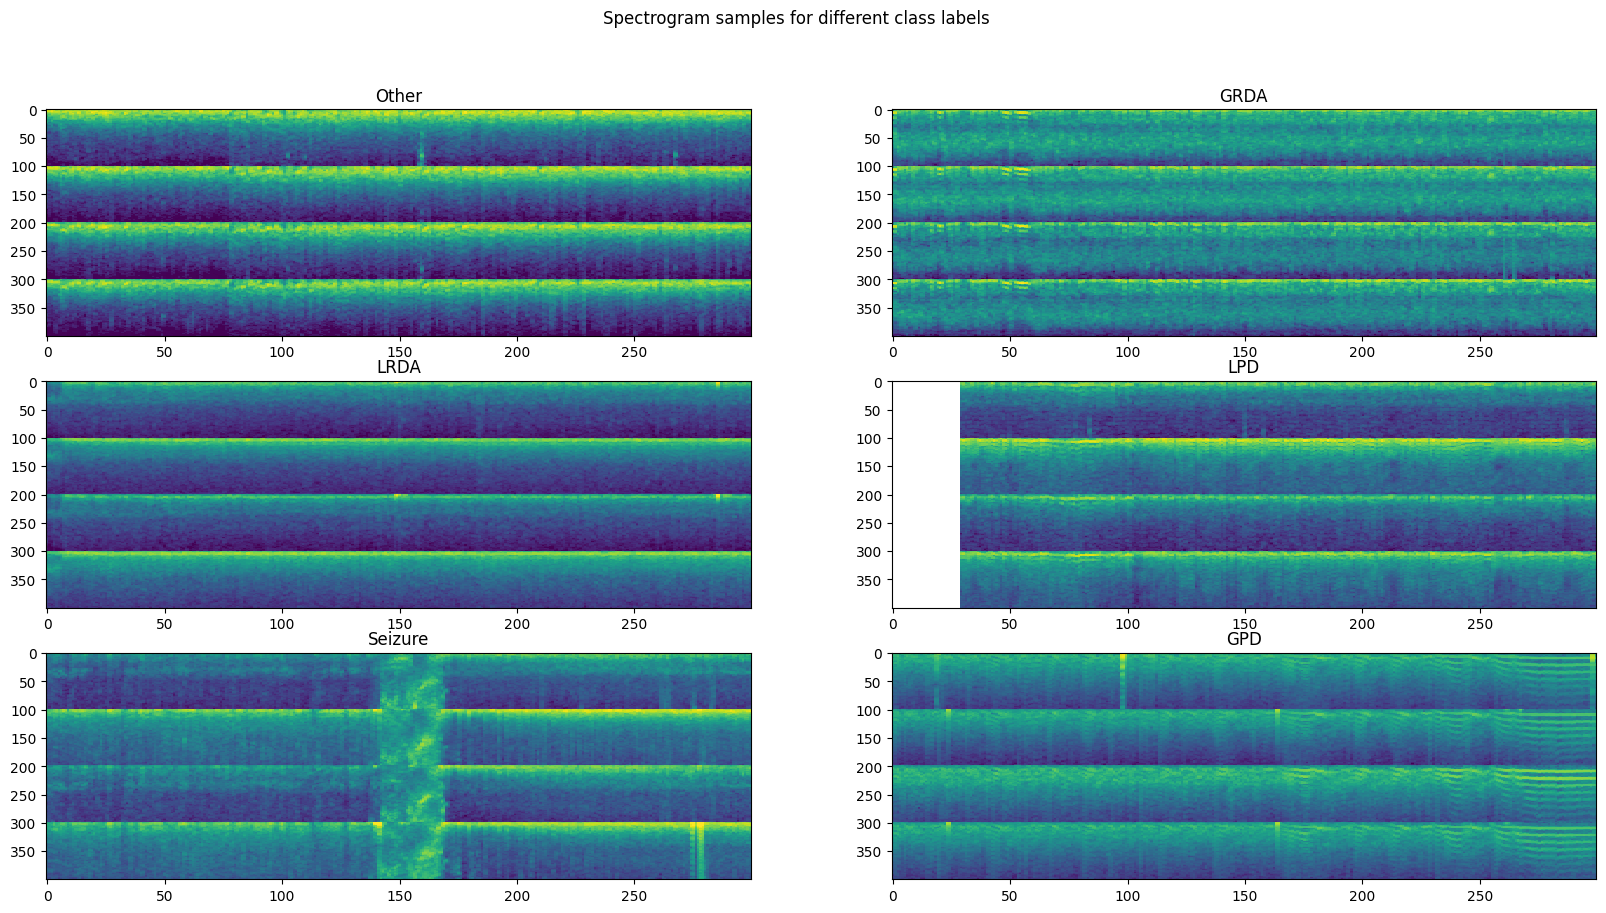

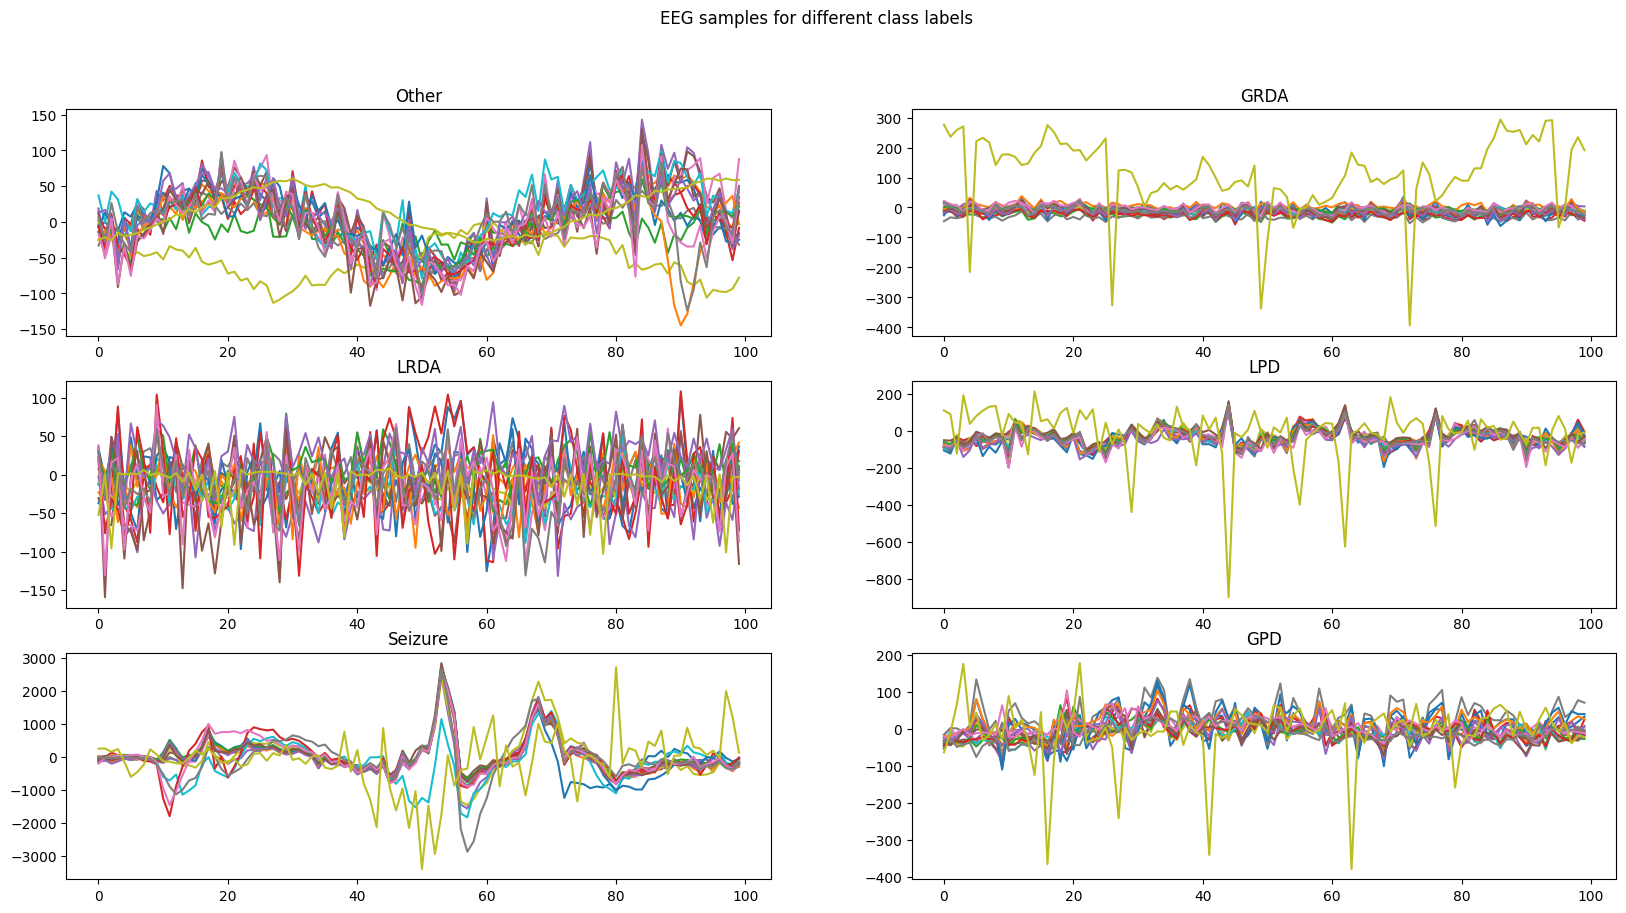

In [7]:
#Data Visualization

labels = pd.unique(train_df["target"])

spec_fig, spec_ax = plt.subplots(nrows=3, ncols=2)
eeg_fig, eeg_ax = plt.subplots(nrows=3, ncols=2)

spec_fig.set_figheight(10)
spec_fig.set_figwidth(20)

eeg_fig.set_figheight(10)
eeg_fig.set_figwidth(20)

for i, label in enumerate(labels):

    row = train_df.loc[train_df["target"]==label].sample().iloc[0]

    spec_id = row["spectrogram_id"]
    eeg_id = row["eeg_id"]

    start = int(row["spectrogram_label_offset_seconds"]*0.5)
    end = int((row["spectrogram_label_offset_seconds"]+600)*0.5)
    spec = all_spec[spec_id][start:end].T

    start = int(row["eeg_label_offset_seconds"]*200)
    end = int((row["eeg_label_offset_seconds"]+50)*200)
    eeg = all_eeg[eeg_id][start:end:100].T

    #Process image for display
    spec = np.clip(spec, np.exp(-4), np.exp(8))
    spec = np.log(spec)

    r,c = divmod(i,2)

    spec_ax[r][c].imshow(spec, interpolation='nearest', aspect='auto')
    spec_ax[r][c].set_title(label)

    for channel in range(eeg.shape[0]):
        eeg_ax[r][c].plot(eeg[channel])

    eeg_ax[r][c].set_title(label)

spec_fig.suptitle("Spectrogram samples for different class labels")
eeg_fig.suptitle("EEG samples for different class labels")

spec_fig.show()
# eeg_fig.show()

In [8]:
class HMSDataset(Dataset):

    def __init__(self,
                 df:pd.DataFrame = None,
                 aug: bool = False) -> None:
        

        super(HMSDataset, self).__init__()

        self.df = df

        self.eeg_sample_freq = 200 # 200 Hz
        self.spec_sample_freq = 0.5 # 0.5 Hz
    
        
        #data augmentation
        self.aug = aug
        self.transforms = A.Compose([
            A.HorizontalFlip(p=0.5)
        ])

    def format_data(self, eeg:np.array, spec:np.array) -> Tuple[torch.tensor]:

        #Epsilon for numerical stability during division (prevent division by zero)
        eps = 1e-6

        #Convert data from saved float16 to float32 during training and testing
        eeg = eeg.astype(dtype=np.float32)
        spec = spec.astype(dtype=np.float32)

        #Normalising and getting rid of Nans
        eeg_mean = np.nanmean(eeg.flatten())
        eeg_std = np.nanstd(eeg.flatten())
        eeg = (eeg-eeg_mean)/(eeg_std+eps)
        eeg = np.nan_to_num(eeg, nan=0.0)

        #Limiting range of spec data
        spec = np.clip(spec, np.exp(-4), np.exp(8))
        spec = np.log(spec)
        
        #Normalising and getting rid of Nans
        spec_mean = np.nanmean(spec.flatten())
        spec_std = np.nanstd(spec.flatten())
        spec = (spec-spec_mean)/(spec_std+eps)
        spec = np.nan_to_num(spec, nan=0.0)
        
        #If data augmentation
        if self.aug:

            eeg = self.transforms(image=eeg)["image"]
            spec = self.transforms(image=spec)["image"]

        #Convert to tensors
        eeg = torch.tensor(eeg.copy())
        spec = torch.tensor(spec.copy())

        return eeg, spec


    def __getitem__(self, index) -> dict:
    
        row = self.df.iloc[index]

        eeg_id = row["eeg_id"]
        spec_id = row["spectrogram_id"]

        #EEG Sub-sampling
        start = int(row["eeg_label_offset_seconds"]*self.eeg_sample_freq)
        end = int((row["eeg_label_offset_seconds"]+50)*self.eeg_sample_freq)
        eeg = all_eeg[eeg_id][start:end].T
        
        #Spectrogram Sub-sampling
        start = int(row["spectrogram_label_offset_seconds"]*self.spec_sample_freq)
        end = int((row["spectrogram_label_offset_seconds"]+600)*self.spec_sample_freq)
        spec = all_spec[spec_id][start:end].T

        #Normalizing and getting rid of Nans
        eeg, spec = self.format_data(eeg, spec)

        #Convert label to tensor
        label = torch.tensor(row[label_cols], dtype=torch.float32)

        return eeg, spec, label


    def __len__(self):

        return self.df.shape[0]

    @staticmethod
    def collate_fn(batch):

        eeg, spec, label = zip(*batch)
        
        if eeg is not None:
            eeg = torch.stack(eeg, dim=0).float()
        
        if spec is not None:
            spec = torch.stack(spec, dim=0).float().unsqueeze(1).expand(-1,3,-1,-1)

        if label is not None:            
            label = torch.stack(label, dim=0)
        
        return {
            "eeg": eeg,
            "spec": spec,
            "label": label
        }
    

In [9]:
#Check dataset object is working

test_dataset = HMSDataset(df=test_df)

print([data.shape for data in test_dataset[0]])

print(test_dataset[0])

[torch.Size([19, 10000]), torch.Size([400, 300]), torch.Size([6])]
(tensor([[ 2.3614,  2.3194,  2.4823,  ..., -1.7455, -1.6031, -1.6775],
        [-0.3700, -0.2605, -0.1144,  ..., -2.2169, -2.3075, -2.4801],
        [ 0.0102,  0.2174,  0.3497,  ..., -0.6527, -0.7875, -0.9105],
        ...,
        [-0.0809, -0.0693, -0.6586,  ...,  0.1719, -0.3792, -0.2762],
        [-0.3010, -0.1300, -0.2249,  ...,  0.6544,  0.4266,  0.3476],
        [ 0.0321, -0.1489, -0.3506,  ..., -0.0801, -0.3042, -0.0270]]), tensor([[ 0.3566,  0.4194,  0.5765,  ...,  1.3942,  0.8542,  1.0623],
        [ 0.6647,  0.5925,  0.9843,  ...,  1.4696,  1.0413,  1.1379],
        [ 0.8955,  0.7546,  1.0413,  ...,  1.4917,  1.0032,  1.2002],
        ...,
        [-0.5482, -0.5900, -0.4620,  ..., -0.8459, -1.1279, -1.4918],
        [-0.6362, -0.5900, -0.3586,  ..., -0.9148, -1.1597, -1.1941],
        [-0.5175, -0.4072, -0.4188,  ..., -1.0199, -1.0705, -1.0982]]), tensor([0., 0., 0., 1., 0., 0.]))


/tmp/ipykernel_421734/839579866.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[label_cols], dtype=torch.float32)


### Model

Load your model here, the current models are supported:

1. CNN
    - ConvNext
    - EfficientNet b0
    - EfficientNet v2s
2. Custom Architecture
    - Contrastive CNNs

In [14]:
model_config = {
    "model_name": "efficientnet_v2s",
    "num_features": 256,
    "num_classes": 6,
    "use_contrastive": False,
}

# model = CNNDetector(model_config).to(device)
model = ContrastiveDetector(model_config).to(device)

ContrastiveDetector(
  (kl_loss): KLDivLoss()
  (backbone_eeg): Sequential(
    (0): Conv1d(19, 64, kernel_size=(7,), stride=(5,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): TemporalBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
      (norm_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): TemporalBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, dilation=(3,), bias=False)
      (norm_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): TemporalBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, dilation=(9,), bias=False

### Training and Testing

Validation is done every `test_step` to check if model is overfitting on training data.

Testing is done at the end of every epoch with the model produced by that epoch.

Training and testing metrics can be viewed in tensorboard as mentioned in the README.

In [15]:
@torch.no_grad()
def validate(model, valid_dataloader):

    model.eval()

    loss_fn = nn.KLDivLoss(reduction="batchmean")

    loss = torch.tensor([0.]).to(device)

    for batch in tqdm(valid_dataloader):

        for key in batch:

            batch[key] = batch[key].to(device)

        predictions = model(batch)
        
        predictions = F.log_softmax(predictions,dim=1)

        loss += loss_fn(predictions,batch["label"])

    loss = loss / len(valid_dataloader)

    model.train()

    print("Validation loss", loss.item())

    return loss.item()

@torch.no_grad()
def test(model, test_dataloader):

    model.eval()

    loss_fn = nn.KLDivLoss(reduction="batchmean")

    num_classes = 6

    acc = MulticlassAccuracy(average="macro", num_classes=num_classes)
    f1_score = torch.tensor([0.]).to(device)
    loss = torch.tensor([0.]).to(device)
     
    for batch in tqdm(test_dataloader):

        for key in batch:
            batch[key] = batch[key].to(device)

        predictions = model(batch)

        loss += loss_fn(F.log_softmax(predictions, dim=1), batch["label"])

        predictions = F.softmax(predictions, dim=1)

        predictions = torch.argmax(predictions, dim=1)

        classes = torch.argmax(batch["label"], dim=1)

        f1_score += multiclass_f1_score(predictions, classes, num_classes=num_classes)

        acc.update(predictions, classes)

    model.train()

    f1_score /= len(test_dataloader)
    loss /= len(test_dataloader)

    return acc.compute(), f1_score, loss

#training

def train_epoch(model=None,
          train_dataloader=None,
          valid_dataloader=None,
          test_dataloader=None,
          optimiser = None,
          train_config=None,
          valid_config=None,
          lr_scheduler=None,
          min_valid_loss=100.,
          min_test_loss=100.,
          model_name="model",
          epoch=0,
          logger=None):
    
    """
    Training Function
    """

    assert(train_dataloader is not None)
    
    assert(model is not None)

    #Training Params

    save_model = train_config.get("save_model", True)
    to_model_keys = ["spec", "eeg", "label"]
    valid_step = valid_config.get("valid_step", 1000)
    verbose_step = train_config.get("verbose_step", 10)

    print(model_name)
    
    model.train()
    
    for itr, batch in tqdm(enumerate(train_dataloader)):

#       print(batch["eeg"].shape)

        #Train One Iteration

        #Load data to GPU

        for key in to_model_keys:

            batch[key] = batch[key].to(device)

        predictions = model(batch)

        if "contrastive" in model_name:

            klloss, contrastive_loss = model.get_loss(predictions, batch["label"])

            loss = klloss+contrastive_loss
        
        else:
            
            loss = model.get_loss(predictions,batch["label"])
        
        optimiser.zero_grad()

        loss.backward()

        optimiser.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        if itr%verbose_step==0:
            print(f"Training itr {itr}/{len(train_dataloader)}")
            for param_group in optimiser.param_groups:
                lr = param_group['lr']
                break
            
            if "contrastive" in model_name:
                print("Training KL Loss: ", klloss.item(), "Training Contrastive Loss: ", contrastive_loss.item(), "Learning Rate:", lr)
                logger.log_metrics({"train/klloss":klloss, "train/contrastiveloss": contrastive_loss, "train/lr": lr}, itr+epoch*len(train_dataloader))
            else:
                print("Training Loss: ", loss.item(), "Learning Rate:", lr)
                logger.log_metrics({"train/loss":loss, "train/lr": lr}, itr+epoch*len(train_dataloader))
        
        #Validation
        
        if itr%valid_step==0 and itr>0 and valid_dataloader is not None:
            print("Validation")
            valid_loss = validate(model, valid_dataloader)
            
            if valid_loss < min_valid_loss and save_model:
                min_valid_loss = valid_loss
            logger.log_metrics({"valid/loss":valid_loss}, itr+epoch*len(train_dataloader))
        
    #Test
    if test_dataloader is not None:
        acc, f1_score, loss = test(model, test_dataloader)
        if loss < min_test_loss:
            min_test_loss = loss
            save_path = os.path.join(DATA_ROOT,"models")
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_path, f"{model_name}_best.pt"))
            print(f"Best test loss {min_test_loss}, model saved!")
        logger.log_metrics({"test/acc":acc, "test/f1_score":f1_score, "test/loss":loss}, itr+epoch*len(train_dataloader))
    return min_valid_loss, min_test_loss

In [16]:
def train(model=None,
          optimiser=None,
          lr_scheduler=None,
          train_config=None,
          valid_config=None,
          test_dataloader=None,
          model_name="model",
          logger=None):
    
    train_batch_size = train_config.get("batch_size", 32)
    num_epochs = train_config.get("num_epochs", 10)
    valid_folds = train_config.get("valid_folds", 5)
    valid_batch_size = valid_config.get("batch_size", 32)
    train_workers = train_config.get("workers", 1)
    valid_workers = valid_config.get("workers", 1)

    min_valid_loss = 100.
    min_test_loss = 100.

    for epoch in range(num_epochs):

        print("Epoch", epoch)

        #KGFolds
        fold = np.random.randint(valid_folds)
        train_df_fold = train_df[train_df["fold"]!=fold]
        valid_df = train_df[train_df["fold"]==fold]
        train_dataset = HMSDataset(train_df_fold, aug=True)
        valid_dataset = HMSDataset(valid_df, aug=False)

        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size = train_batch_size,
            shuffle=True,
            num_workers=train_workers,
            collate_fn=train_dataset.collate_fn
        )

        valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size = valid_batch_size,
            shuffle=True,
            num_workers=valid_workers,
            collate_fn=valid_dataset.collate_fn
        )

        min_valid_loss, min_test_loss = train_epoch(model=model,
                    train_dataloader=train_dataloader,
                    valid_dataloader=valid_dataloader,
                    test_dataloader=test_dataloader,
                    optimiser=optimiser,
                    train_config=train_config,
                    valid_config=valid_config,
                    lr_scheduler=lr_scheduler,
                    min_valid_loss=min_valid_loss,
                    min_test_loss=min_test_loss,
                    model_name=model_name,
                    epoch=epoch,
                    logger=logger)
        print("Min Valid Loss", min_valid_loss, "Min Test Loss", min_test_loss)

#### Hyperparameters

Configuration of hyperparamters for training and validation/testing is shown below.

If you would like to train the contrastive detector, set `model_name` to "contrastive_{backbone_name}", e.g. "contrastive_efficientnetb0". Otherwise, Set `model_name` to "cnn_detector_{backbone_name}".

- `batch_size`: size of one mini-batch of data per forward pass of the model during training, validation and testing respectively
- `lr`: learning rate, depends on optimiser and learning rate scheduler
- `save_model`: saves the best model determined by validation loss
- `valid_folds`: set during dataset geneartion, the number of groups to have in Group KFolds training
- `verbose_step`: iteration step interval to print and log training metrics
- `valid_step`: iteration step interval to perform validation on model and save best model by validation loss
- `workers`: number of CPU workers to load dataset for training, validation, and testing. A higher number requires more RAM but may speed up training

In [17]:
train_config = {
    "batch_size": 32,
    "num_epochs": 5,
    "lr": 1e-3,
    "save_model": True,
    "workers": 1,
    "verbose_step": 100,
    "weight_decay": 1e-4,
    "valid_folds": VALID_FOLDS,
}

valid_config = {
    "batch_size": 64,
    "workers": 1,
    "valid_step": 500
}

lr = train_config.get("lr", 1e-3)
weight_decay = train_config.get("weight_decay", 0.)
model_name = "contrastive"
num_epochs = train_config.get("num_epochs", 1)
folds = train_config.get("valid_folds", 5)
train_batch_size = train_config.get("batch_size", 32)
test_batch_size = valid_config.get("batch_size", 32)


logger = TensorBoardLogger(f"logs/{model_name}", name=model_name)

optimiser = torch.optim.Adam(
model.parameters(),
lr=lr,
weight_decay=weight_decay
)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser,
    max_lr=lr,
    epochs=num_epochs,
    steps_per_epoch=int((folds-1)/folds*train_df.shape[0]/train_batch_size)+10
)

test_dataset = HMSDataset(df=test_df)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=test_batch_size,
    collate_fn=test_dataset.collate_fn
)

torch.cuda.empty_cache()

train(model=model,
      train_config=train_config,
      valid_config=valid_config,
      test_dataloader=test_dataloader,
      model_name=model_name,
      optimiser=optimiser,
      lr_scheduler=lr_scheduler,
      logger=logger)

    

Epoch 0
contrastive


0it [00:00, ?it/s]

/tmp/ipykernel_421734/839579866.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[label_cols], dtype=torch.float32)


Training itr 0/1202
Training KL Loss:  4.326633453369141 Training Contrastive Loss:  0 Learning Rate: 4.0000718651559374e-05
Training itr 100/1202
Training KL Loss:  3.5356874465942383 Training Contrastive Loss:  0 Learning Rate: 4.731232458808946e-05
Training itr 200/1202
Training KL Loss:  2.8513035774230957 Training Contrastive Loss:  0 Learning Rate: 6.874272265430651e-05
Training itr 300/1202
Training KL Loss:  2.9664154052734375 Training Contrastive Loss:  0 Learning Rate: 0.00010365180448417455
Training itr 400/1202
Training KL Loss:  2.6069185733795166 Training Contrastive Loss:  0 Learning Rate: 0.00015099686451240733
Training itr 500/1202
Training KL Loss:  2.158017873764038 Training Contrastive Loss:  0 Learning Rate: 0.0002093637447321907
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

/tmp/ipykernel_421734/839579866.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[label_cols], dtype=torch.float32)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Validation loss 0.7668266296386719
Training itr 600/1202
Training KL Loss:  1.953023076057434 Training Contrastive Loss:  0 Learning Rate: 0.00027700907443185254
Training itr 700/1202
Training KL Loss:  1.7903162240982056 Training Contrastive Loss:  0 Learning Rate: 0.0003519123432442852
Training itr 800/1202
Training KL Loss:  1.9606398344039917 Training Contrastive Loss:  0 Learning Rate: 0.00043183625212995895
Training itr 900/1202
Training KL Loss:  2.065847873687744 Training Contrastive Loss:  0 Learning Rate: 0.0005143935396592931
Training itr 1000/1202
Training KL Loss:  2.0670714378356934 Training Contrastive Loss:  0 Learning Rate: 0.0005971182875482926
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_421734/839579866.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[label_cols], dtype=torch.float32)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)


Validation loss 0.8821833729743958
Training itr 1100/1202
Training KL Loss:  1.466266393661499 Training Contrastive Loss:  0 Learning Rate: 0.0006775395756097369
Training itr 1200/1202
Training KL Loss:  1.8624212741851807 Training Contrastive Loss:  0 Learning Rate: 0.0007532552861071061


  0%|          | 0/84 [00:00<?, ?it/s]

/tmp/ipykernel_421734/839579866.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[label_cols], dtype=torch.float32)


Best test loss tensor([0.8491], device='cuda:0'), model saved!
Min Valid Loss 0.7668266296386719 Min Test Loss tensor([0.8491], device='cuda:0')
Epoch 1
contrastive


0it [00:00, ?it/s]

Training itr 0/1202
Training KL Loss:  2.069685459136963 Training Contrastive Loss:  0 Learning Rate: 0.0007547057640276813


/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)


Training itr 100/1202
Training KL Loss:  2.0047428607940674 Training Contrastive Loss:  0 Learning Rate: 0.0008232932413689126
Training itr 200/1202
Training KL Loss:  1.637336015701294 Training Contrastive Loss:  0 Learning Rate: 0.0008828215990165849
Training itr 300/1202
Training KL Loss:  1.4574862718582153 Training Contrastive Loss:  0 Learning Rate: 0.0009315127738834456
Training itr 400/1202
Training KL Loss:  1.6666250228881836 Training Contrastive Loss:  0 Learning Rate: 0.0009679124006194855
Training itr 500/1202
Training KL Loss:  1.34617280960083 Training Contrastive Loss:  0 Learning Rate: 0.0009909332523088843
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.643083393573761
Training itr 600/1202
Training KL Loss:  1.8287907838821411 Training Contrastive Loss:  0 Learning Rate: 0.000999887715043859
Training itr 700/1202
Training KL Loss:  1.6560370922088623 Training Contrastive Loss:  0 Learning Rate: 0.0009989488189705994
Training itr 800/1202
Training KL Loss:  1.515303373336792 Training Contrastive Loss:  0 Learning Rate: 0.000995179222721968
Training itr 900/1202
Training KL Loss:  1.3072986602783203 Training Contrastive Loss:  0 Learning Rate: 0.0009886904512612289
Training itr 1000/1202
Training KL Loss:  1.2235041856765747 Training Contrastive Loss:  0 Learning Rate: 0.0009795181364908678
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.7480654716491699
Training itr 1100/1202
Training KL Loss:  1.2984257936477661 Training Contrastive Loss:  0 Learning Rate: 0.0009677126465009682
Training itr 1200/1202
Training KL Loss:  1.3780198097229004 Training Contrastive Loss:  0 Learning Rate: 0.0009533388089820503


  0%|          | 0/84 [00:00<?, ?it/s]

Best test loss tensor([0.8392], device='cuda:0'), model saved!
Min Valid Loss 0.643083393573761 Min Test Loss tensor([0.8392], device='cuda:0')
Epoch 2
contrastive


0it [00:00, ?it/s]

/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)


Training itr 0/1202
Training KL Loss:  1.4251303672790527 Training Contrastive Loss:  0 Learning Rate: 0.0009530256538704397
Training itr 100/1202
Training KL Loss:  1.3833303451538086 Training Contrastive Loss:  0 Learning Rate: 0.0009361135115920281
Training itr 200/1202
Training KL Loss:  1.3374459743499756 Training Contrastive Loss:  0 Learning Rate: 0.0009168065426583897
Training itr 300/1202
Training KL Loss:  1.333847165107727 Training Contrastive Loss:  0 Learning Rate: 0.0008952107677605748
Training itr 400/1202
Training KL Loss:  1.7065824270248413 Training Contrastive Loss:  0 Learning Rate: 0.000871444776149247
Training itr 500/1202
Training KL Loss:  1.2562451362609863 Training Contrastive Loss:  0 Learning Rate: 0.000845639074423489
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.4077305793762207
Training itr 600/1202
Training KL Loss:  1.2936795949935913 Training Contrastive Loss:  0 Learning Rate: 0.0008179353698776673
Training itr 700/1202
Training KL Loss:  1.3481281995773315 Training Contrastive Loss:  0 Learning Rate: 0.0007884857923417252
Training itr 800/1202
Training KL Loss:  1.5822298526763916 Training Contrastive Loss:  0 Learning Rate: 0.0007574520587880278
Training itr 900/1202
Training KL Loss:  1.0230209827423096 Training Contrastive Loss:  0 Learning Rate: 0.0007250045852921661
Training itr 1000/1202
Training KL Loss:  1.1446479558944702 Training Contrastive Loss:  0 Learning Rate: 0.0006913215512242259
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.5106176137924194
Training itr 1100/1202
Training KL Loss:  1.6516735553741455 Training Contrastive Loss:  0 Learning Rate: 0.0006565879208093442
Training itr 1200/1202
Training KL Loss:  1.0287415981292725 Training Contrastive Loss:  0 Learning Rate: 0.000620994427430473


  0%|          | 0/84 [00:00<?, ?it/s]

Min Valid Loss 0.4077305793762207 Min Test Loss tensor([0.8392], device='cuda:0')
Epoch 3
contrastive


0it [00:00, ?it/s]

/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Training itr 0/1202
Training KL Loss:  1.0122323036193848 Training Contrastive Loss:  0 Learning Rate: 0.0006202751224848331


/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)


Training itr 100/1202
Training KL Loss:  0.853528618812561 Training Contrastive Loss:  0 Learning Rate: 0.0005840059536779711
Training itr 200/1202
Training KL Loss:  1.0840226411819458 Training Contrastive Loss:  0 Learning Rate: 0.0005472754925133859
Training itr 300/1202
Training KL Loss:  1.6163411140441895 Training Contrastive Loss:  0 Learning Rate: 0.0005102854376051195
Training itr 400/1202
Training KL Loss:  0.9441496729850769 Training Contrastive Loss:  0 Learning Rate: 0.00047323891307880924
Training itr 500/1202
Training KL Loss:  0.9552990198135376 Training Contrastive Loss:  0 Learning Rate: 0.00043633935315267897
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.4542277157306671
Training itr 600/1202
Training KL Loss:  1.096530556678772 Training Contrastive Loss:  0 Learning Rate: 0.00039978938501571213
Training itr 700/1202
Training KL Loss:  0.863845705986023 Training Contrastive Loss:  0 Learning Rate: 0.00036378971613747907
Training itr 800/1202
Training KL Loss:  1.2232816219329834 Training Contrastive Loss:  0 Learning Rate: 0.0003285380321197522
Training itr 900/1202
Training KL Loss:  1.0649378299713135 Training Contrastive Loss:  0 Learning Rate: 0.00029422791114215596
Training itr 1000/1202
Training KL Loss:  1.0087063312530518 Training Contrastive Loss:  0 Learning Rate: 0.00026104776096297507
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.4290883541107178
Training itr 1100/1202
Training KL Loss:  1.091123104095459 Training Contrastive Loss:  0 Learning Rate: 0.00022917978431238623
Training itr 1200/1202
Training KL Loss:  1.0286160707473755 Training Contrastive Loss:  0 Learning Rate: 0.00019879897835946734


  0%|          | 0/84 [00:00<?, ?it/s]

Best test loss tensor([0.8174], device='cuda:0'), model saved!
Min Valid Loss 0.4077305793762207 Min Test Loss tensor([0.8174], device='cuda:0')
Epoch 4
contrastive


0it [00:00, ?it/s]

Training itr 0/1202
Training KL Loss:  0.6903207898139954 Training Contrastive Loss:  0 Learning Rate: 0.00019820769186297346


/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/benluo/miniconda3/envs/hbac_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_421734/839579866.py:34: RuntimeWarning: invalid value encountered in subtract
  eeg = (eeg-eeg_mean)/(eeg_std+eps)


Training itr 100/1202
Training KL Loss:  0.9903507232666016 Training Contrastive Loss:  0 Learning Rate: 0.00016951560806295973
Training itr 200/1202
Training KL Loss:  0.9260344505310059 Training Contrastive Loss:  0 Learning Rate: 0.0001426383298793154
Training itr 300/1202
Training KL Loss:  0.6866909265518188 Training Contrastive Loss:  0 Learning Rate: 0.00011772344897266662
Training itr 400/1202
Training KL Loss:  0.8625849485397339 Training Contrastive Loss:  0 Learning Rate: 9.490778085767242e-05
Training itr 500/1202
Training KL Loss:  0.8173670768737793 Training Contrastive Loss:  0 Learning Rate: 7.431661360563149e-05
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.46194180846214294
Training itr 600/1202
Training KL Loss:  0.7445887327194214 Training Contrastive Loss:  0 Learning Rate: 5.606301984793902e-05
Training itr 700/1202
Training KL Loss:  0.7143362164497375 Training Contrastive Loss:  0 Learning Rate: 4.0247235858397865e-05
Training itr 800/1202
Training KL Loss:  0.7138161063194275 Training Contrastive Loss:  0 Learning Rate: 2.695611112404248e-05
Training itr 900/1202
Training KL Loss:  0.5716627240180969 Training Contrastive Loss:  0 Learning Rate: 1.62626314270539e-05
Training itr 1000/1202
Training KL Loss:  0.8812476396560669 Training Contrastive Loss:  0 Learning Rate: 8.225518056677635e-06
Validation


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss 0.4408777058124542
Training itr 1100/1202
Training KL Loss:  0.5918583869934082 Training Contrastive Loss:  0 Learning Rate: 2.888905351996413e-06
Training itr 1200/1202
Training KL Loss:  0.9663812518119812 Training Contrastive Loss:  0 Learning Rate: 2.820983462736311e-07


  0%|          | 0/84 [00:00<?, ?it/s]

Min Valid Loss 0.4077305793762207 Min Test Loss tensor([0.8174], device='cuda:0')
